# Project 2: Market-basket analysis - IMDB dataset

Project for the course of Algorithms for Massive Dataset <br> Nicolas Facchinetti 961648 <br> Antonio Belotti 960822

# Set up the Spark enviorment

We start by dowloading and installing all the needed tool to deal with Spark. In particular we are interested in obtainig a Java enviorment since Spark in written in Scala and so it need a JVM to run. Then we can download Apache Spark 3.1.2 with Hadoop 3.2 by the Apache CDN and uncompress it. Finally we can get and install PySpark, an interface for Apache Spark in Python

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://dlcdn.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!rm spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark

--2022-02-20 12:54:45--  https://dlcdn.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228834641 (218M) [application/x-gzip]
Saving to: ‘spark-3.1.2-bin-hadoop3.2.tgz’

spark-3.1.2-bin-had 100%[===================>] 218.23M   179MB/s    in 1.2s    

2022-02-20 12:54:47 (179 MB/s) - ‘spark-3.1.2-bin-hadoop3.2.tgz’ saved [228834641/228834641]



The next step is to correctly set the path in our remote enviorment to use the obtained tools.

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

Finally we can import PySpark in the project

In [3]:
import findspark
findspark.init("spark-3.1.2-bin-hadoop3.2")# SPARK_HOME
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

# Download the dataset from Kaggle

First install the Python module of Kaggle to download the dataset from its datacenter

In [4]:
!pip install kaggle

Then load kaggle.json, a file containing your API credentials to be able to use the services offered by Kaggle

In [5]:
from google.colab import files

uploaded = files.upload()
  
# Move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


Now we can download the dataset

In [6]:
!kaggle datasets download 'ashirwadsangwan/imdb-dataset'

 99% 1.43G/1.44G [00:13<00:00, 108MB/s]
100% 1.44G/1.44G [00:13<00:00, 118MB/s]


We now must unzip the compressed archive to use it. Once done we can also remove it.

In [7]:
!unzip imdb-dataset.zip && rm imdb-dataset.zip

Archive:  imdb-dataset.zip
  inflating: name.basics.tsv.gz      
  inflating: name.basics.tsv/name.basics.tsv  
  inflating: title.akas.tsv.gz       
  inflating: title.akas.tsv/title.akas.tsv  
  inflating: title.basics.tsv.gz     
  inflating: title.basics.tsv/title.basics.tsv  
  inflating: title.principals.tsv.gz  
  inflating: title.principals.tsv/title.principals.tsv  
  inflating: title.ratings.tsv.gz    
  inflating: title.ratings.tsv/title.ratings.tsv  


# Preapare the data for Spark

We can directly load the downloaded and extracted .tsv file in a Spark DataFrame by using the command read.csv(). We directly pass to the method the columns in which we are interested.

In [8]:
df_principals = spark.read.csv("/content/title.principals.tsv/title.principals.tsv", sep=r'\t', header=True).select('tconst','nconst','category')
df_principals.show(10)

+---------+---------+---------------+
|   tconst|   nconst|       category|
+---------+---------+---------------+
|tt0000001|nm1588970|           self|
|tt0000001|nm0005690|       director|
|tt0000001|nm0374658|cinematographer|
|tt0000002|nm0721526|       director|
|tt0000002|nm1335271|       composer|
|tt0000003|nm0721526|       director|
|tt0000003|nm5442194|       producer|
|tt0000003|nm1335271|       composer|
|tt0000003|nm5442200|         editor|
|tt0000004|nm0721526|       director|
+---------+---------+---------------+
only showing top 10 rows



In [9]:
df_basics = spark.read.csv("/content/title.basics.tsv/title.basics.tsv", sep=r'\t', header=True).select('tconst','titleType')
df_basics.show(10)

+---------+---------+
|   tconst|titleType|
+---------+---------+
|tt0000001|    short|
|tt0000002|    short|
|tt0000003|    short|
|tt0000004|    short|
|tt0000005|    short|
|tt0000006|    short|
|tt0000007|    short|
|tt0000008|    short|
|tt0000009|    movie|
|tt0000010|    short|
+---------+---------+
only showing top 10 rows



By inspecting the content of the column 'category' of df_principlas we can see that there are many jobs other than actors and actress (which are the two we are interested in)

In [10]:
df_principals.select("category").distinct().show()

+-------------------+
|           category|
+-------------------+
|            actress|
|           producer|
|             writer|
|           composer|
|           director|
|               self|
|              actor|
|             editor|
|    cinematographer|
|      archive_sound|
|production_designer|
|    archive_footage|
+-------------------+



Similarly we can do the same thing with df_basics and the column 'titleType' to see how many categories a title can have.

In [11]:
df_basics.select("titleType").distinct().show()

+------------+
|   titleType|
+------------+
|    tvSeries|
|tvMiniSeries|
|     tvMovie|
|   tvEpisode|
|       movie|
|   tvSpecial|
|       video|
|   videoGame|
|     tvShort|
|       short|
+------------+



Once the data is loaded in a Spark DataFrame we can use the PySpark SQL module for processing the data. We start by exctracting only actors and actress from df_principals

In [12]:
pre = df_principals.count()
df_principals.createOrReplaceTempView("PRINCIPALS") # create a temporary table on DataFrame
df_principals = spark.sql("SELECT * from PRINCIPALS WHERE category ='actor' OR category='actress'")
print("We reduced the number of row from {} to {}".format(pre, df_principals.count()))

We reduced the number of row from 36468817 to 14818798


 And then we do the same thing with movies in df_basics

In [13]:
pre = df_basics.count()
df_basics.createOrReplaceTempView("BASICS") # create a temporary table on DataFrame
df_basics = spark.sql("SELECT * from BASICS WHERE titleType ='movie'")
print("We reduced the number of row from {} to {}".format(pre, df_basics.count()))

We reduced the number of row from 6321302 to 536034


We can now see that we have two DataFrame, one containing only the movies and the other only the people which play as actor/actress in a title. To do the desired maket-basket analysis we have to pivot our tconst as rows, so each row stands for one titleId, and then including a list of nconst identifiers of the actors that played in it.

In [14]:
df_basics.show(10)

+---------+---------+
|   tconst|titleType|
+---------+---------+
|tt0000009|    movie|
|tt0000147|    movie|
|tt0000335|    movie|
|tt0000502|    movie|
|tt0000574|    movie|
|tt0000615|    movie|
|tt0000630|    movie|
|tt0000675|    movie|
|tt0000676|    movie|
|tt0000679|    movie|
+---------+---------+
only showing top 10 rows



In [15]:
df_principals.show(10)

+---------+---------+--------+
|   tconst|   nconst|category|
+---------+---------+--------+
|tt0000005|nm0443482|   actor|
|tt0000005|nm0653042|   actor|
|tt0000007|nm0179163|   actor|
|tt0000007|nm0183947|   actor|
|tt0000008|nm0653028|   actor|
|tt0000009|nm0063086| actress|
|tt0000009|nm0183823|   actor|
|tt0000009|nm1309758|   actor|
|tt0000011|nm3692297|   actor|
|tt0000014|nm0166380|   actor|
+---------+---------+--------+
only showing top 10 rows



So we start by joining the two dataframe to extract from df_principals only the records with tconst related to a movie. We can also discard the category column since is no longer useful.

In [16]:
basket_data = df_principals.join(df_basics, "tconst").select(df_principals.tconst, df_principals.nconst).sort("tconst")
basket_data.show(10)

+---------+---------+
|   tconst|   nconst|
+---------+---------+
|tt0000009|nm0183823|
|tt0000009|nm1309758|
|tt0000009|nm0063086|
|tt0000335|nm0675239|
|tt0000335|nm1010955|
|tt0000335|nm0675260|
|tt0000335|nm1012612|
|tt0000335|nm1012621|
|tt0000335|nm1011210|
|tt0000502|nm0215752|
+---------+---------+
only showing top 10 rows



Then we can remove hypothetical duplicated row and then aggregate the data using tconst identifier.

In [17]:
from pyspark.sql import functions as F
basket_data = basket_data.dropDuplicates()
basket_data = basket_data.groupBy("tconst").agg(F.collect_list("nconst").alias("nconsts")).sort('tconst')

We then sort the transaction data in order to simplify candidates generation.

In [18]:
basket_data = basket_data.withColumn('nconsts', F.sort_array('nconsts'))

In [19]:
print("There are {} titleId buckets".format(basket_data.count()))
basket_data.show(10, False)

There are 393656 titleId buckets
+---------+------------------------------------------------------------------+
|tconst   |nconsts                                                           |
+---------+------------------------------------------------------------------+
|tt0000009|[nm0063086, nm0183823, nm1309758]                                 |
|tt0000335|[nm0675239, nm0675260, nm1010955, nm1011210, nm1012612, nm1012621]|
|tt0000502|[nm0215752, nm0252720]                                            |
|tt0000574|[nm0170118, nm0846887, nm0846894, nm3002376]                      |
|tt0000615|[nm0218953, nm0240418, nm0346387, nm0581353, nm0888988, nm3071427]|
|tt0000630|[nm0624446]                                                       |
|tt0000676|[nm0097421, nm0140054]                                            |
|tt0000679|[nm0000875, nm0122665, nm0933446, nm2924919]                      |
|tt0000793|[nm0691995]                                                       |
|tt0000862|[nm02645

As we can see above we now have the data in the correct format to do our analysis: in each row we have the identifier of a movie and in the second column the list of the idenfiers of the actors that played in it.
Since we have done all the needed pre-processing computation on the data we can transform our DataFrame in a RDD to apply map-reduce functions.

In [43]:
basket_data = basket_data.rdd

# Apriori classic

We start by implementing the classic Apriori algorithm. In particular we search until no more k-itemsets are found.

In [20]:
def generate_candidate_k_set(frequent_kmin1_set, k):
  """
  frequent_kmin1_set: list
  k: int

  return: list

  Take as input an integer k and a frequent k-1 itemset. Return as output the candidate k itemset obtained from frequent_kmin1_set
  """
  if k < 2:
    raise ValueError("k must be >= 2")
  
  candidates = []

  # cast singleton itemset into list
  if type(frequent_kmin1_set[0]) != tuple:
    frequent_kmin1_set = [[x] for x in frequent_kmin1_set]

  for x in frequent_kmin1_set:
    for y in frequent_kmin1_set:
      if x[:k - 2] == y[:k - 2] and x[k - 2] < y[k - 2]:
        candidates.append((*x[:k - 2], x[k - 2], y[k - 2]))
  return candidates

In [21]:
import functools
from itertools import tee
                    
def apriori_unlimited_k(transactions, support_threshold):
  """
  transactions: list [(key, [elements]), ...]
  support_threshold: int

  return: list [(itemset, support), ...]
  """
  useIterator,copyIterator = tee(transactions)

  frequent_elements = {}

  # count singletons
  counter = {}
  for _, transaction in useIterator:
    for x in transaction:
      # if is not present in counter set return 0 and add 1, otherwise add 1 to entry x
      counter[x] = counter.get(x,0) + 1

  # filter out imtesets with count >= the threshold
  frequent_elements[1] = [(k, v) for k, v in counter.items() if v >= support_threshold]
  
  k = 2
  while frequent_elements[k - 1]:
    all_candidate_sets = generate_candidate_k_set([e[0] for e in frequent_elements[k - 1]], k)

    useIterator, copyIterator = tee(copyIterator)
    counter = {}
    for _, transaction in useIterator:
      for candidate_set in all_candidate_sets:
        # check that all the element in the candidate set are in transaction
        if all([candidate_element in transaction for candidate_element in candidate_set]):
          counter[candidate_set] = counter.get(candidate_set, 0) + 1
    # keep only the itemsets with counter >= the threshold
    frequent_elements[k] = [(itemset, occ) for itemset, occ in counter.items() if occ >= support_threshold]
    k += 1
  return functools.reduce(lambda a, b: a + b, frequent_elements.values())

In [22]:
test = [
        ("t1", ["I1", "I3", "I4"]),
        ("t2", ["I2", "I3", "I5"]),
        ("t3", ["I1", "I2", "I3", "I5"]),
        ("t4", ["I2", "I5"]),
  ]

apriori_unlimited_k(test, 2)

[('I1', 2),
 ('I3', 3),
 ('I2', 3),
 ('I5', 3),
 (('I1', 'I3'), 2),
 (('I3', 'I5'), 2),
 (('I2', 'I3'), 2),
 (('I2', 'I5'), 3),
 (('I2', 'I3', 'I5'), 2)]

# Apriori with MAP-REDUCE

Follow an implementatio of the Apriori algorithm using a map-reduce approach.

In [23]:
def filter_candidate(transaction, all_candidate_sets):
  """
  transaction: list
  all_candidate_set: list

  return: list
  return only the candidate set which are in the transaction
  """
  exist = []
  for candidate_set in all_candidate_sets:
    if all([candidate_element in transaction for candidate_element in candidate_set]):
      exist.append(candidate_set)
  return exist

In [24]:
def apriorihmap_unlimited_k(data, support_threshold):
  """ 
  data: Pyspark.rdd 
    [
      [tconst, [nconst,]],
    ]
  support_threshold: int

  return: Pyspark.rdd
  """
  nconst_rdd = data.map(lambda x: x[1])

  # find singletone
  frequent_items_rdd = nconst_rdd.flatMap(lambda x: x) \
        .map(lambda elem: (elem,1)) \
        .reduceByKey(lambda a,b: a+b) \
        .filter(lambda x: x[1] >= support_threshold)

  # to save frequent itemsets for each k iteration
  frequent_elements = frequent_items_rdd.map(lambda x: x[0]).collect()
  k = 2
  # until there are no more frequent itemesets with support >= threshold
  while frequent_elements:
    # generate all the candidate k itemset from frequent_elements (k - 1)
    all_candidate_sets = generate_candidate_k_set(frequent_elements, k) 
    
    frequent_k_rdd = nconst_rdd.flatMap(lambda x: filter_candidate(x, all_candidate_sets)) \
              .map(lambda x: (x,1)) \
              .reduceByKey(lambda a,b: a+b) \
              .filter(lambda x: x[1] >= support_threshold)
    frequent_items_rdd = frequent_items_rdd.union(frequent_k_rdd)

    # add new frequent element
    frequent_elements = frequent_k_rdd.map(lambda x: x[0]).collect()
    k += 1
  return frequent_items_rdd

# SON

We must define a function for the second step to properly count the number of occurrence of frequent itemsets in a partition.

In [25]:
def count_in_partition(data, frequent):
  """
  data: iterable
  frequent:  pyspark.Broadcast

  return: list 
  
  count the occurence of each itemeset in frequent in the partion data
  """
  # prepare data for processing
  frequent = frequent.value   # extract broadcasted values
  data = list(data)

  # check foreach frequent itemset
  for frequent_item in frequent:
    # trick to cast single element to list → not remove in the str duplicate char using set()
    if type(frequent_item) is not tuple:
      to_check = [frequent_item]
    else:
      to_check = frequent_item
      
    c = 0     # counter
    # and foreach row of the dataset
    for itemset in data:
      # check if the frequent itemset is subset of the items of the row
      if set(to_check).issubset(itemset[1]):
        c += 1
    yield (frequent_item, c)

In [26]:
def count_in_partition_v2(data, frequent):
  frequent = frequent.value   # extract broadcasted values
  data = list(data)

  for frequent_itemset in frequent.keys():
    # convert frequent singleton to list if needed. It will be converted to set later
    freq_itemset_copy = frequent_itemset if type(frequent_itemset) is not str else [frequent_itemset]
    
    # count all the transactions that contain freq_itemset_copy
    c = sum(1 for _,transaction in data if set(freq_itemset_copy).issubset(transaction))

    yield (frequent_itemset, c)

Then the implementation of SON with a two step map-reduce. The first finds out the frequent itemsets in the partition and the latter go to count them in the dataset and filters out the ones with support greater than threshold.

In [27]:
def son_m_r(data, support):
  """
  data: Pyspark.rdd 
    [
      [tconst, [nconst,]],
    ]
  support: int

  return: Pyspark.rdd
  """
  reduced_support = support//data.getNumPartitions()
  # use apriori on every partition
  first_map = data.mapPartitions(lambda partition: apriori_unlimited_k(partition, reduced_support)).map(lambda x: (x[0], None))
  first_reduce = first_map.reduceByKey(lambda a,b: a) # reduce just to remove duplicates
  
  # extract the frequent itemsets and broadcast them to worker nodes
  frequent_items = [x[0] for x in first_reduce.collect()]

  # same but using spark distinct()
  # frequent_items = data.mapPartitions(lambda partition: apriori_unlimited_k(partition, reduced_support)).map(lambda x: x[0]).distinct().collect()

  frequent_items = spark.sparkContext.broadcast(frequent_items)

  second_map = data.mapPartitions(lambda partition: count_in_partition(partition, frequent_items))
  second_reduce = second_map.reduceByKey(lambda a,b: a+b).filter(lambda x: x[1] >= support)
  return second_reduce

In [28]:
def son_m_r_v2(data, support):
  reduced_support = support/data.getNumPartitions()

  candidate_frequent_itemsets_rdd = data.mapPartitions(lambda partition: apriori_unlimited_k(partition, reduced_support)).map(lambda x: x[0])

  # broadcast the frequent items to worker nodes
  candidate_frequent_itemsets_bv = spark.sparkContext.broadcast(
      {x:True for x in candidate_frequent_itemsets_rdd.collect()}
  )
  
  second_map = data.mapPartitions(lambda partition: count_in_partition_v2(partition, candidate_frequent_itemsets_bv))
  frequent_itemsets = second_map.reduceByKey(lambda a,b: a+b).filter(lambda x: x[1] >= support)
  return frequent_itemsets

# Test of the algorithms

We extract a subset of 1000 rows from the dataset to test out that our algorithms work as expected. We define min_support as 1% of the count of the rows.

In [29]:
import pandas as pd
minsup = 0.01
num_rows = 1000
sup = minsup*num_rows
sup

10.0

In [30]:
minid = basket_data.take(num_rows)
minid = spark.sparkContext.parallelize(minid)
minid.take(5)

[Row(tconst='tt0000009', nconsts=['nm0063086', 'nm0183823', 'nm1309758']),
 Row(tconst='tt0000335', nconsts=['nm0675239', 'nm0675260', 'nm1010955', 'nm1011210', 'nm1012612', 'nm1012621']),
 Row(tconst='tt0000502', nconsts=['nm0215752', 'nm0252720']),
 Row(tconst='tt0000574', nconsts=['nm0170118', 'nm0846887', 'nm0846894', 'nm3002376']),
 Row(tconst='tt0000615', nconsts=['nm0218953', 'nm0240418', 'nm0346387', 'nm0581353', 'nm0888988', 'nm3071427'])]

In [31]:
import time
execution_times = {}

We start by exectuing the classic implementation of apriori. Is compulsory to  collect the data from the RDD since this is a non distributed implementation.

In [32]:
before = time.time()

apriori1 = list(apriori_unlimited_k(minid.collect(), sup))

execution_times["apriori_seq"] = time.time() - before

The we have the Apriori implementation with map-reduce

In [33]:
before = time.time()

apriori2 = apriorihmap_unlimited_k(minid, sup).collect()

execution_times["apriori_MR"] = time.time() - before

Follow the implementation with SON. The data must be repartioned on the finded sweet-spot number of partitions

In [35]:
minid = minid.repartition(4)

before = time.time()

son = son_m_r(minid, sup).collect()

execution_times["son"] = time.time() - before

In [36]:
before = time.time()

son_v2 = son_m_r_v2(minid, sup).collect()

execution_times["son_dict"] = time.time() - before

Then we also train the in-library implementation of FPGrowth to have a comparison with a correct algorithm

In [37]:
from pyspark.ml.fpm import FPGrowth
fpGrowth = FPGrowth(itemsCol="nconsts")

before = time.time()

# initialize
fpGrowth.setMinSupport(minsup)
model = fpGrowth.fit(minid.toDF())

# get itemsets
fp_growth = model.freqItemsets.collect()

execution_times["fpgrowth"] = time.time() - before

In [38]:
# trasform the output of FPGrowth to be the same as our implementations
def trasform_format(data):
  res = []
  for d in data:
    if len(d.items) == 1:
      # ("item") -> "item"
      itemset = d.items[0]
    else:
      # ("z", "a") -> ("a", "z")
      itemset = tuple(sorted(d.items))

    res.append((itemset, d.freq))
  return res

# convert result
fp_growth = trasform_format(fp_growth)

Let's put the obtained result in a tabular way.

In [39]:
df1 = pd.DataFrame([x[1] for x in apriori1], index=[x[0] for x in apriori1], columns =['Apriori'])
df2 = pd.DataFrame([x[1] for x in apriori2], index=[x[0] for x in apriori2], columns =['Apriori MR'])
df3 = pd.DataFrame([x[1] for x in son], index=[x[0] for x in son], columns =['SON'])
df4 = pd.DataFrame([x[1] for x in fp_growth], index=[x[0] for x in fp_growth], columns =['FPGrowth'])
df5 = pd.DataFrame([x[1] for x in son_v2], index=[x[0] for x in son_v2], columns =['SON_V2'])

df = pd.concat([df1, df2, df3, df5, df4], axis=1)
df["Equal"] = df.nunique(axis = 1, dropna=False) == 1       
df

,Apriori,Apriori MR,SON,SON_V2,FPGrowth,Equal
nm0140054,14,14,14,14,14,True
nm0528022,10,10,10,10,10,True
nm0681933,16,16,16,16,16,True
nm0516974,20,20,20,20,20,True
nm0110838,11,11,11,11,11,True
nm0292407,16,16,16,16,16,True
nm0926280,18,18,18,18,18,True
nm0676473,14,14,14,14,14,True
nm0392059,14,14,14,14,14,True
nm0163540,14,14,14,14,14,True


In [40]:
execution_times

{'apriori_MR': 2.0682215690612793,
 'apriori_seq': 0.28475427627563477,
 'fpgrowth': 2.2357470989227295,
 'son': 12.718713521957397,
 'son_dict': 1.4240660667419434}

# Perfomance comparison

In [41]:
import time

def getOccPerLen(resultset):
  singleton = 0
  doubletons = 0
  triplets = 0  
  for itemset, support in resultset:
    if type(itemset) == str:
      singleton += 1
    if len(itemset) == 2:
      doubletons += 1
    if len(itemset) == 3:
      triplets +=1
  return [singleton, doubletons, triplets]

def timeit(method, *args):
  before = time.time()
  res = method(*args)

  if type(res) != list:
    res = res.collect()
  
  return time.time() - before, res

In [44]:
import pandas as pd

st_perc = .0005
nrows = 393656 # basket_data.count()

exectime = {}
singletons = {}
doubletons = {}
triplets = {}

num_partitions = spark.sparkContext._jsc.sc().getExecutorMemoryStatus().size() * 4
basket_data = basket_data.repartition(num_partitions)

print(f"Benchmark on {nrows} rows")
while st_perc < .0022:
  print(f"  st: {st_perc}%")
  st = nrows * st_perc

  ex1, its1 = timeit(apriori_unlimited_k, basket_data.collect(), st)
  s1,d1,t1 = getOccPerLen(its1)
  #print(f"   apriori \t{ex1}")

  ex2, its2 = timeit(apriorihmap_unlimited_k, basket_data, st)
  s2,d2,t2 = getOccPerLen(its2)
  #print(f"   apriori hm\t{ex2}")

  ex4, its4 = timeit(son_m_r_v2, basket_data, st)
  s4,d4,t4 = getOccPerLen(its4)
  #print(f"   son hm\t{ex4}")

  exectime[st_perc] = [ex1,ex2,ex4]
  singletons[st_perc] = [s1,s2,s4]
  doubletons[st_perc] = [d1,d2,d4]
  triplets[st_perc] = [t1,t2,t4]

  if st_perc >= 0.0010:
    st_perc += .0002
  else:
    st_perc += .0001

exectimeDF = pd.DataFrame(exectime, index=["Apriori", "Apriori MR", "SON HM"])
singletonsDF = pd.DataFrame(singletons, index=["Apriori", "Apriori MR", "SON HM"])
doubletonsDF = pd.DataFrame(doubletons, index=["Apriori", "Apriori MR", "SON HM"])
tripletsDF = pd.DataFrame(triplets, index=["Apriori", "Apriori MR", "SON HM"])

Benchmark on 393656 rows
  st: 0.0005%
  st: 0.0006000000000000001%
  st: 0.0007000000000000001%
  st: 0.0008000000000000001%
  st: 0.0009000000000000002%
  st: 0.0010000000000000002%
  st: 0.0012000000000000003%
  st: 0.0014000000000000004%
  st: 0.0016000000000000005%
  st: 0.0018000000000000006%
  st: 0.0020000000000000005%


In [45]:
# Check for consistent result
singletonsDF = singletonsDF.transpose()
singletonsDF["Equal"] = singletonsDF.nunique(axis = 1, dropna=False) == 1
assert singletonsDF["Equal"].all()

doubletonsDF = doubletonsDF.transpose()
doubletonsDF["Equal"] = doubletonsDF.nunique(axis = 1, dropna=False) == 1
assert doubletonsDF["Equal"].all()

tripletsDF = tripletsDF.transpose()
tripletsDF["Equal"] = tripletsDF.nunique(axis = 1, dropna=False) == 1
assert tripletsDF["Equal"].all()

In [46]:
itemsetCountDF = pd.DataFrame()
itemsetCountDF["# Singletons"] = singletonsDF.drop(["Apriori MR", "SON HM", "Equal"], axis = 1)
itemsetCountDF["# Doubletons"] = doubletonsDF.drop(["Apriori MR", "SON HM", "Equal"], axis = 1)
itemsetCountDF["# Triplets"] = tripletsDF.drop(["Apriori MR", "SON HM", "Equal"], axis = 1)

In [47]:
itemsetCountDF.transpose()

,0.0005,0.0006,0.0007,0.0008,0.0009,0.0010,0.0012,0.0014,0.0016,0.0018,0.0020
# Singletons,89,48,28,15,10,6,4,3,1,1,1
# Doubletons,1,1,0,0,0,0,0,0,0,0,0
# Triplets,0,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

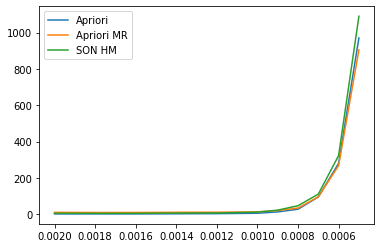

In [48]:
import matplotlib.pyplot as plt

fig = exectimeDF.T.sort_index(ascending=False).plot().get_figure()
plt.gca().invert_xaxis()
fig.savefig('exectime.png')

#from google.colab import files
#files.download('exectime.png')

In [51]:
print(exectimeDF.T.to_latex())
print(itemsetCountDF.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &     Apriori &  Apriori MR &       SON HM \\
\midrule
0.0005 &  970.065916 &  904.597095 &  1089.687631 \\
0.0006 &  280.070612 &  267.718065 &   322.889096 \\
0.0007 &   94.992104 &   95.566126 &   110.739193 \\
0.0008 &   27.663077 &   33.943501 &    46.756983 \\
0.0009 &   12.765596 &   20.111274 &    22.532161 \\
0.0010 &    5.505735 &   13.194169 &    11.593682 \\
0.0012 &    3.253653 &   11.070552 &     7.043262 \\
0.0014 &    2.472198 &   10.589934 &     6.245012 \\
0.0016 &    1.722727 &    9.662168 &     4.982123 \\
0.0018 &    1.758922 &    9.475686 &     5.060649 \\
0.0020 &    1.754561 &   10.397350 &     5.160399 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
{} &  \# Singletons &  \# Doubletons &  \# Triplets \\
\midrule
0.0005 &            89 &             1 &           0 \\
0.0006 &            48 &             1 &           0 \\
0.0007 &            28 &             0 &           0 \\
0.0008 &            15 &             0